In [1]:
import zipfile

# Specify the path to your zip file
zip_file = 'testdataset.zip'

# Specify the directory where you want to unzip
extract_dir = 'unzipped_images1/'

# Unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Folder unzipped successfully!")


Folder unzipped successfully!


In [2]:
import zipfile

# Specify the path to your zip file
zip_file = 'traindataset.zip'

# Specify the directory where you want to unzip
extract_dir = 'unzipped_images2/'

# Unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Folder unzipped successfully!")


Folder unzipped successfully!


Training SVM model...
Evaluating the model...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   5.4s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   5.6s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   5.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.8s
[C

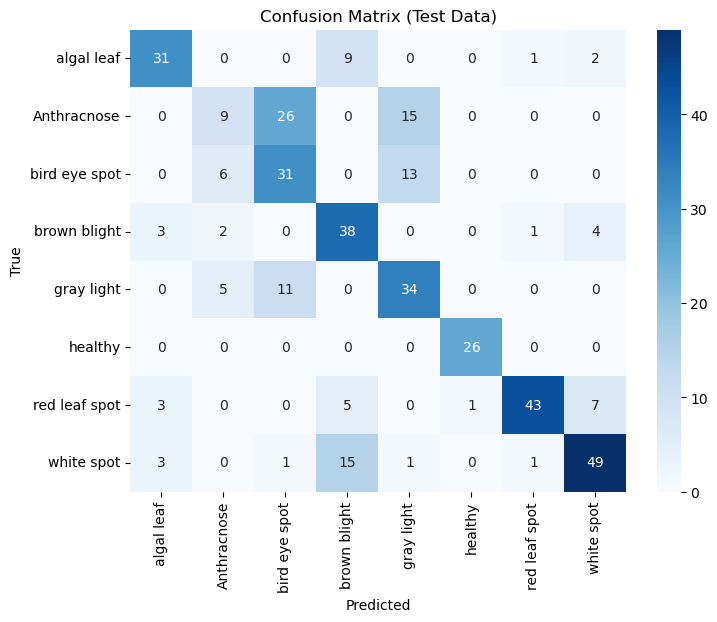

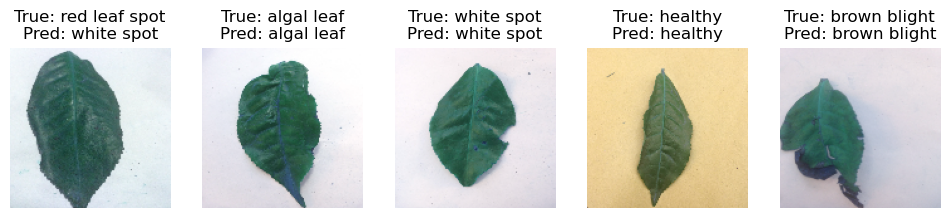

Model saved as 'leaf_disease_svm_model.pkl'
Validation Accuracy: 69.39%
Test Accuracy: 65.91%


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Paths to the dataset
TRAIN_DIR = "unzipped_images2/traindataset"
TEST_DIR = "unzipped_images1/testdataset"

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128

# Function to load images and labels
def load_images_and_labels(directory):
    images = []
    labels = []
    classes = os.listdir(directory)
    
    for label, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            # Read and resize the image
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels), classes

# Load training and testing datasets
train_images, train_labels, class_names = load_images_and_labels(TRAIN_DIR)
test_images, test_labels, _ = load_images_and_labels(TEST_DIR)

#Weighted Classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Flatten images for machine learning
train_images_flat = train_images.reshape(len(train_images), -1)
test_images_flat = test_images.reshape(len(test_images), -1)

# Split train data for validation
X_train, X_val, y_train, y_val = train_test_split(train_images_flat, train_labels, test_size=0.2, random_state=42)

# Train an SVM classifier
print("Training SVM model...")
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Evaluate the model
print("Evaluating the model...")
val_predictions = svm_model.predict(X_val)
test_predictions = svm_model.predict(test_images_flat)

#Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)


print("\nValidation Classification Report:")
print(classification_report(y_val, val_predictions, target_names=class_names))

print("\nTest Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

# Confusion Matrix for Test Data
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Visualizing some predictions
def visualize_predictions(images, true_labels, predictions, class_names, num_samples=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        idx = np.random.randint(len(images))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[predictions[idx]]}")
        plt.axis('off')
    plt.show()

# Visualize predictions on test data
visualize_predictions(test_images, test_labels, test_predictions, class_names)

# Save the model
import joblib
joblib.dump(svm_model, 'leaf_disease_svm_model.pkl')
print("Model saved as 'leaf_disease_svm_model.pkl'")


# Calculate accuracy on the validation dataset
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Calculate accuracy on the test dataset
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

